In [1]:
import os
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.models import load_model, Sequential
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.optimizers import Adam
from keras.api.losses import SparseCategoricalCrossentropy
from keras import layers, activations, Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2024-10-19 20:44:13.092867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 20:44:13.110812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 20:44:13.116736: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 20:44:13.130597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 20:44:14.393189: W tensorflow/compiler/tf2

In [2]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 299
img_width   = 299
channel     = 3

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
HISTORY = "history"
LATEST_MODEL_NAME = "latest_model.keras"

# Using default sort from VSCode
# Colon polyps, Colorectal cancer, Normal mucosa...
CLASS_ARR = ["Colon polyps", "Colorectal cancer", "Normal mucosa and vascular pattern in the large bowel"]

In [3]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + ".keras")
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [4]:
def make_evaluation_metrics(model: Model, validation_dataset: tf.data.Dataset):
    predictions = np.array([])
    labels = np.array([])
    categories = CLASS_ARR

    for x, y in validation_dataset:
        y_pred = model.predict(x)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions = np.concatenate([predictions, y_prediction])
        labels = np.concatenate([labels, y.numpy()])

    print("---------------EVALUATION METRICS---------------")

    print(f"Accuracy Score:     {accuracy_score(y_true=labels, y_pred=predictions)}")
    print(f"Precision Score:    {precision_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"Recall Score:       {recall_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"F1 Score:           {f1_score(y_true=labels, y_pred=predictions, average=None)}")

    print("----------------CONFUSION MATRIX----------------")

    plt.figure(num=69420, figsize=(plt.rcParams.get('figure.figsize')))
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt="d")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

In [5]:
(train_ds, val_ds) = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision",
    validation_split=0.2,
    subset="both",
    seed=69420,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2426 files belonging to 3 classes.
Using 1941 files for training.
Using 485 files for validation.


I0000 00:00:1729345463.178702   21495 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729345463.224966   21495 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729345463.225215   21495 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729345463.226757   21495 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
image_augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip(),
    ])
}

In [7]:
# Pretrained models
inception_model = keras.applications.InceptionV3(
    include_top=False,
    classes=3,
    input_shape=(img_height, img_width, channel)
)

In [8]:
inception_model.trainable = False

for layer in inception_model.layers[-10:]:
    layer.trainable = True

In [9]:
inputs = keras.Input(shape=image_size_with_channel)
x = image_augmentation["training"](inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = inception_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
x = Dense(128)(x)
x = Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
x = Dense(64)(x)
x = Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
outputs = Dense(units=3, activation=activations.softmax)(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,370,467 (85.34 MB)

 Trainable params: 566,979 (2.16 MB)

 Non-trainable params: 21,803,488 (83.17 MB)

In [10]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(patience=5)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [12]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=10, callbacks=[get_early_stopping()])

Epoch 1/10


2024-10-19 20:45:03.905655: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729345503.983484   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.024891   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.027262   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.029749   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.032367   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.041644   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.045026   21583 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345504.048208   21583 gpu_t

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.3834 - loss: 1.4540

W0000 00:00:1729345521.062743   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.064859   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.066617   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.068414   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.070213   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.072613   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.075032   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.077106   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345521.079174   21581 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.3836 - loss: 1.4536

W0000 00:00:1729345524.117231   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.119846   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.122383   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.124612   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.126695   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.129542   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.132637   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.135846   21581 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345524.139355   21581 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 42s 402ms/step - accuracy: 0.3838 - loss: 1.4531 - val_accuracy: 0.5711 - val_loss: 1.0422
Epoch 2/10


W0000 00:00:1729345532.793143   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345532.794478   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345532.795840   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345532.797366   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345532.798881   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345532.800386   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729345532.801788   21578 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.4684 - loss: 1.2697 - val_accuracy: 0.5835 - val_loss: 1.0680
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.4874 - loss: 1.1485 - val_accuracy: 0.6536 - val_loss: 0.9171
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 259ms/step - accuracy: 0.5534 - loss: 1.0656 - val_accuracy: 0.6227 - val_loss: 0.9712
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.5801 - loss: 1.0223 - val_accuracy: 0.6680 - val_loss: 0.8710
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 263ms/step - accuracy: 0.5942 - loss: 0.9765 - val_accuracy: 0.6866 - val_loss: 0.8014
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.6074 - loss: 0.9621 - val_accuracy: 0.6866 - val_loss: 0.8525
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.6572 - loss: 0.8847 - val_accuracy: 0.6866 - val_loss: 0.8561
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.6480 - loss: 0.8502 - val_accuracy: 0.713

In [18]:
save_model(model, "inceptionv3_default_dataset_")

Model has succesfully saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
---------------EVALUATION METRICS---------------
Accuracy Score:     0.7154639175257732
Precision Score:    [0.56147541 0.33333333 0.90707965]
Recall Score:       [0.84567901 0.19230769 0.69023569]
F1 Score:           [0.67487685 0.24390244 0.78393881]
----------------CONFUSION MATRIX----------------


2024-10-19 20:48:10.237667: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


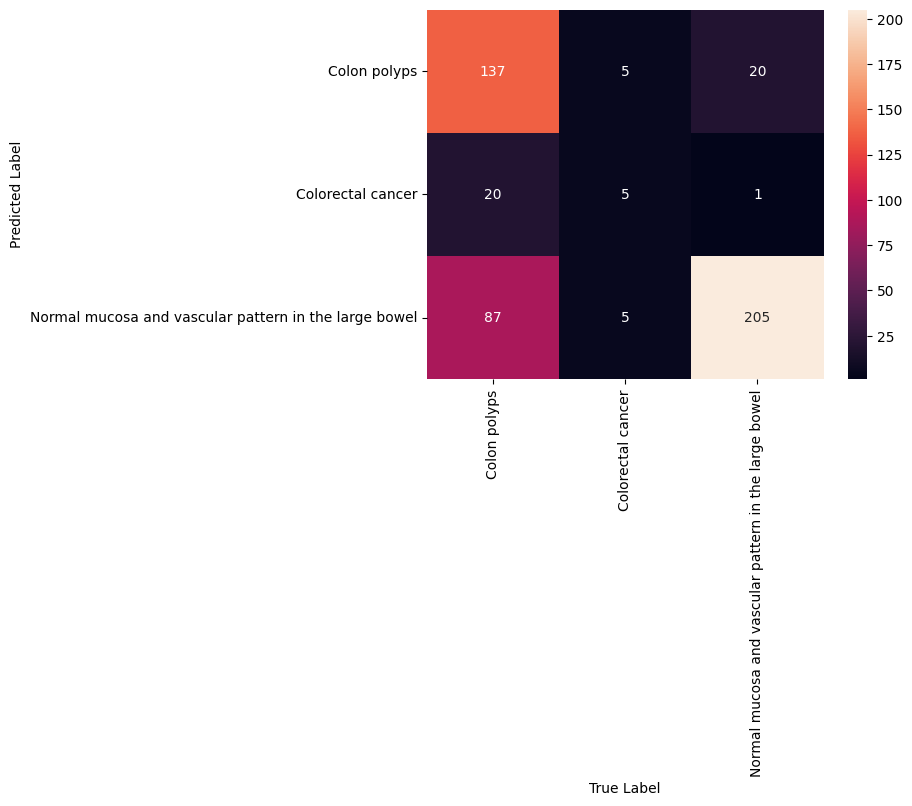

In [13]:
make_evaluation_metrics(model, val_ds)